In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

enlighten the front panels uses a lot of energy and cause glitches on the power rail. never the less an eluminated panel looks much better and the different types of connectors can be marked with different colors.


|color|type|[V]|
|---  |--- |---|
|<button class="button is-danger">red</button>| | audio signal | +-5 |
|<button class="button is-success">green</button>| | cv signal | +-5 |
|<button class="button is-warning">yellow</button>| | cv pulse or gate | +10 |
|<button class="button is-text">white</button>| | cv pulse or gate | +10 |


**the chip should be powered by +5V/GND. With higher voltage the heat dissipation will be to big and the chip will be damaged.**

# dc led driver

when there is a DC signal which is positive only and the signal has to be buffered the simgle transistor driver comes in handy. It is built around the common base transistor amplifier. The Led can be connected to the collector of the transisitor. The current for the LED can be set with Rx and calculated using simple ohms law.

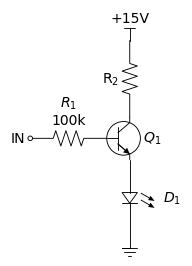

In [2]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)

d.add(elm.Dot('left', lftlabel='IN', open=True))
d.add(elm.Resistor(label='$R_1$\n100k'))
Q = d.add(elm.BjtNpn(circle='True', label='$Q_1$', to='base'))

d.add(elm.LED("down", label='$D_1$', at=Q.emitter))
d.add(elm.Ground)

d.add(elm.Resistor("up", label="R$_2$", at=Q.collector))
d.add(elm.Vdd(label="+15V"))

d.draw()

This is the first setup with the 4069 as voltage follower. C1 and C3 are the dc blocking capacitors. When we choose R1 and R2 as 100kOhm we would excpect a gain of one. 

In [3]:
V = 5 - 0.2 - 1.7
Ie = V / 5100 # U=R*I -> I=U/R
print("Calculated Emitter current: %f A" % Ie)

Ib = (10 - 0.6) / 100000
print("Calculated Base current: %f A" % Ib)
print("Calculated current: %f A" % (Ib+Ie))



Calculated Emitter current: 0.000608 A
Calculated Base current: 0.000094 A
Calculated current: 0.000702 A


Emitter Current: -0.000679


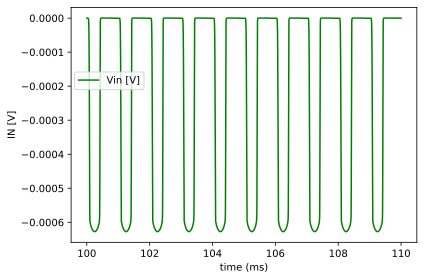

In [4]:
circuit = Circuit('DC led driver')
circuit.include(spice_library['BC547B'])
circuit.include(spice_library['LED2'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 10 AC 5V SIN(0 5V 1k)')

circuit.BJT('1', 'col', 'base', 'em', model="BC547B")

circuit.R(1, 'IN', 'base', 100@u_kΩ)
R = circuit.R(2, '+5V', 'col', 5.1@u_kΩ)

circuit.D(1, 'em', circuit.gnd, model="LED2")

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('savecurrents')

op = simulator.operating_point()
print("Emitter Current: %f" % op['@Q1[ie]'])

analysis  = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=110@u_ms)

#plot the figure
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
#ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
#ax1_buffer.plot(u_ms(analysis['em'].abscissa), analysis['em'], color='Red')
ax1_buffer.plot(u_ms(analysis['@Q1[ie]'].abscissa), analysis['@Q1[ie]'], color='Green')
ax1_buffer.legend(('Vin [V]', 'Vout (R2=100 kΩ)', 'Vout (R2=125 kΩ)'), loc=(0.01,0.65))

plt.tight_layout()
plt.show()

# ac led driver


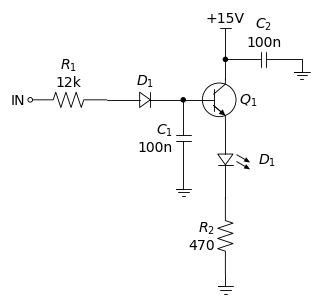

In [5]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)

d.add(elm.Dot('left', lftlabel='IN', open=True))
d.add(elm.Resistor(label='$R_1$\n12k'))
D = d.add(elm.Diode(label='$D_1$'))
d.add(elm.Dot())
d.add(elm.Line(l=d.unit/4))
Q = d.add(elm.BjtNpn(circle='True', label='$Q_1$', to='base'))

d.add(elm.Capacitor("down", label="$C_1$\n100n", at=D.end))
d.add(elm.Ground())

d.add(elm.LED("down", label='$D_1$', at=Q.emitter))
d.add(elm.Resistor(label='$R_2$\n470'))
d.add(elm.Ground)

L = d.add(elm.Line("up", l=d.unit/4, at=Q.collector))
d.add(elm.Dot())
d.add(elm.Line("up", l=d.unit/4))
d.add(elm.Vdd(label="+15V"))
d.add(elm.Capacitor("right", at=L.end, label="$C_2$\n100n"))
d.add(elm.Ground())

d.draw()

In [6]:
circuit = Circuit('ac led driver')
circuit.include(spice_library['BC547B'])
circuit.include(spice_library['D1N4148'])
circuit.include(spice_library['LED1'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 5V SIN(0 5V 1k)')

circuit.BJT('1', '+5V', 'base', 'em', model="BC547B")

circuit.R(1, 'IN', 'R1', 100@u_kΩ)
circuit.D(1, 'R1', 'base', model="D1N4148")
circuit.C(1, 'base', circuit.gnd, 100@u_nF)

circuit.D(2, 'em', 'D2', model="LED1")
R = circuit.R(2, 'D2', circuit.gnd, 470@u_Ω)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=110@u_ms)

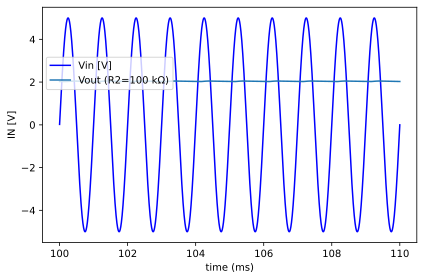

In [7]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
ax1_buffer.plot(u_ms(analysis['em'].abscissa), analysis['em'])
ax1_buffer.legend(('Vin [V]', 'Vout (R2=100 kΩ)', 'Vout (R2=125 kΩ)'), loc=(0.01,0.65))

plt.tight_layout()
plt.show()

# bipolar led driver

Sometimes we do not just want a light indicator for positive signals. For AC signals a bopolar LED could be used. The LED dirver has to produce positive and negative voltages.


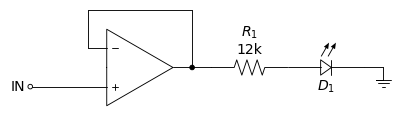

In [69]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)

O = d.add(elm.Opamp())
d.add(elm.Line('left', l=d.unit, xy=O.in2))
d.add(elm.Dot(lftlabel='IN', open=True))

d.add(elm.Line('left', l=d.unit/4, xy=O.in1))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Line('right', tox=O.out+d.unit/4))
d.add(elm.Line('down', toy=O.out))
D = d.add(elm.Dot())
d.add(elm.Line('left', tox=O.out))

d.add(elm.Line('right', l=d.unit/4, xy=D.end))
d.add(elm.Resistor(label='$R_1$\n12k'))
d.add(elm.LED(label='$D_1$'))
d.add(elm.Line(l=d.unit/4))
d.add(elm.Ground())

d.draw()

In [79]:
circuit = Circuit('bipolar led driver')
circuit.include(spice_library['TL072'])
circuit.include(spice_library['LED1'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'IN', circuit.gnd, 'DC 5 AC 5V SIN(0 5V 1k)')

circuit.X('1', 'TL072', 'IN', 'Xo', '+15V', '-15V', 'Xo')
circuit.R(1, 'Xo', 'R1', 500@u_Ω)
circuit.D(1, 'R1', circuit.gnd, model="LED2")
circuit.D(2, circuit.gnd, 'R1', model="LED2")

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('savecurrents')

analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=2@u_ms)
analysis_dc  = simulator.operating_point()

print(f'opamp voltage: {float(analysis_dc.Xo)}, LED: current: {float(analysis_dc["@D1[id]"]*1000)}mA')


opamp voltage: 4.999842244523887, LED: current: 5.749771253922793mA


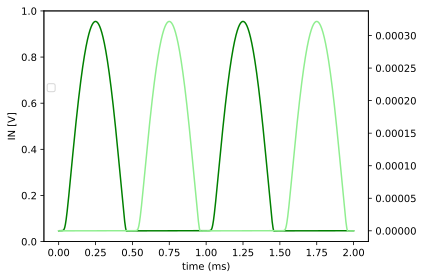

In [39]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
#ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
#ax1_buffer.plot(u_ms(analysis['R1'].abscissa), analysis['R1'], color='Red')
ax1_buffer.legend(('Vin [V]', 'Vout (R2=100 kΩ)', 'Vout (R2=125 kΩ)'), loc=(0.01,0.65))

ax2 = ax1_buffer.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(u_ms(analysis['@D1[id]'].abscissa), analysis['@D1[id]'], color='Green')
ax2.plot(u_ms(analysis['@D2[id]'].abscissa), analysis['@D2[id]'], color='LightGreen')

plt.tight_layout()
plt.show()

$$
\begin{array}{c}
(5V÷ 10) = RFB × 20 mA = RFB = \frac{5V)(10 mA)) = R Ω
\end{array}
$$

In [76]:
R = (5-2.5) / 0.005
print(R)

I = (5-0.7) / 10000
print(I)

500.0
0.00043


in the simulation R2 is unchanched. For R4 the simulation is done with 100kΩ, 500kΩ, 1MΩ and 10MΩ.

# references

1. [CD4069](https://www.ti.com/lit/ds/schs054e/schs054e.pdf) Datasheet
2. [UBE Screamer](http://www.runoffgroove.com/ubescreamer.html) TS-808 workalike built around the CD4049UBE logic IC
3. [WASP Filter](https://www.schmitzbits.de/wasp.html) Jürgen Haibles clone of the EDP Wasp VCF from René Schmitz.